In [1]:
#Importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from ta import add_all_ta_features
from ta.utils import dropna

#Extracts data from the yahoo finance and gives us the latest data
import yfinance as yf

#Importing Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Importing feature selection libraries
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA


#Importing libraries for LSTMs and defining accuracy
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
VOL = ['WEI', 'IVDA', 'TKAT', 'CYRN', 'SLS',
       'XPON', 'HUSN', 'SNMP', 'GREE', 'USX']

In [3]:
#Returns X and y data in dataframe form processed and with TA lib features
#time is 10 years
def process_data(stock_name):
    start = datetime.datetime(2020,4,6)
    end = datetime.datetime(2022,4,6)
    stock = yf.download(stock_name,start,end)
    
    df = add_all_ta_features(
        stock, open="Open", high="High", low="Low", close="Close", volume="Volume")
    
    #Drops columns that have major null values
    
    df.drop(columns = ["trend_psar_up","trend_psar_down"], inplace = True)
    df.dropna(inplace = True)
    
    #Splits data into features and target values
    
    X = df.drop("Close",axis = 1)
    y = df["Close"]

    
    return X, y

In [4]:
# define the lasso regression class
class LassoRegression() :

  # define the constructor and pass
  # learning rate, iterations i.e epochs and l1 penality for Lasso
  def __init__( self, lr, epochs, l1_penality ) :

      self.lr = lr
      self.epochs = epochs
      self.l1_penality = l1_penality
      
  # fit the model on training data
  def fit( self, X, Y ) :
      
      # no_of_training_examples, no_of_features
      self.m, self.n = X.shape
      
      # weight initialization
      self.W = np.zeros( self.n )
      
      self.b = 0
      self.X = X
      self.Y = Y
      
      # gradient descent learning
      for i in range( self.epochs ) :
          self.update_weights()
      return self

  # function to update weights in gradient descent
  def update_weights( self ) :

      Y_pred = self.predict( self.X )
      
      # calculate gradients
      dW = np.zeros( self.n )

      # add or subtract penalty depending upon positivity or negativity of weights
      for j in range( self.n ):
          if self.W[j] > 0 :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      + self.l1_penality ) / self.m
          else :
              dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                      
                      - self.l1_penality ) / self.m

      db = - 2 * np.sum( self.Y - Y_pred ) / self.m
      
      # update weights
      self.W = self.W - self.lr * dW
      self.b = self.b - self.lr * db
      
      return self

  # predict the output
  def predict( self, X ) :
      return X.dot( self.W ) + self.b

In [5]:
def perform_lasso(X_train, X_test):
  # Model training
  model = LassoRegression( epochs = 1000, lr = 0.01, l1_penality = 500 )
  model.fit( X_train, y_train )

  # Prediction on test set
  y_pred = model.predict( X_test )

  return model.W, X_train

In [6]:
from seaborn.utils import axes_ticklabels_overlap
def bar_importance(coeff, X_train, feature_names, thresh):

  # steps for feature importance
  feature_importance = np.std(X_train, 0)*np.array(coeff)
  
  above_threshold ={}
  # print feature name and their importance
  for name,importance in zip(feature_names,feature_importance):
      if abs(importance) >= thresh:
        above_threshold[name] = importance

  #create a dataframe containing feature name and their importance
  dff = pd.DataFrame([])
  dff['features'] = above_threshold.keys()
  dff['importance'] = above_threshold.values()

  d = dff.groupby(['features']).sum().sort_values('importance',ascending=False)
  
  # plot graph for feature importance
  #d['importance'].plot.bar()
  return above_threshold

In [7]:
def create_model(X, y):
    
    #Defines the scaler for scaling down the data to values between 0 and 1. 
    scaler = MinMaxScaler()
    
    y = np.array(y)
    
    #Transforms the target data and feature data
        
    X_transformed = scaler.fit_transform(X)
    y_transformed = scaler.fit_transform(y.reshape(-1,1))
    
    #Splitting the data into training and testing
    
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.2, shuffle = None)
    
    train_len = len(X_train)
    test_len = len(X_test)
    
    X_train = np.array(X_train)
    X_train = X_train.reshape(train_len,-1,1)
    
    #Calls the make_model funtion that creates the sequential LSTM model
    predictor = make_model()
    
    #Trains the data on the new model with the training data for 10 epochs.
    predictor.fit(X_train, y_train, epochs = 10)
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(test_len,-1,1)
    y_test = np.reshape(y_test,(-1,1))
    
    #Here we calculate the predicted values using the trained data.
    
    y_pred = predictor.predict(X_test)
    
    #Inversing the transformed data to get the actual values matching to the real dataset
    
    y_pred_inv_transformed = scaler.inverse_transform(y_pred)
    y_actual_inv_transformed = scaler.inverse_transform(y_test)
    
    #Plotting the graph against the predicted values and real values
    plot_values(y_pred_inv_transformed, y_actual_inv_transformed)   
    
    #Calculating the r2 score to determine how accurate the model is.
    print("The r2 score of this prediction is : ", r2_score(y_actual_inv_transformed, y_pred_inv_transformed))

In [8]:
#Defining the LSTM and adding layers to it
def make_model():
    model = Sequential()
    model.add(LSTM(units = 180, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dense(units = 1))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = "mae")
    
    return model

In [9]:
#The plot function here plots the predicted values against the actual values and displays the figure
def plot_values(pred_vals, actual_vals):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(pred_vals)
    plt.plot(actual_vals)
    plt.show()
    plt.clf()

[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 5s 75ms/step - loss: 0.1788 - mae: 0.3469
Epoch 2/10
11/11 [==============================] - 1s 78ms/step - loss: 0.0320 - mae: 0.1556
Epoch 3/10
11/11 [==============================] - 1s 77ms/step - loss: 0.0178 - mae: 0.1064
Epoch 4/10
11/11 [==============================] - 1s 76ms/step - loss: 0.0083 - mae: 0.0733
Epoch 5/10
11/11 [==============================] - 1s 76ms/step - loss: 0.0029 - mae: 0.0433
Epoch 6/10
11/11 [==============================] - 1s 78ms/step - loss: 0.0019 - mae: 0.0347
Epoch 7/10
11/11 [==============================] - 1s 77ms/step - loss: 0.0016 - mae: 0.0312
Epoch 8/10
11/11 [==============================] - 1s 76ms/step - loss: 0.0015 - mae: 0.0281
Epoch 9/10
11/11 [==============================] - 1s 75ms/step - loss: 0.0012 - mae: 0.0260
Epoch 10/10
11/11 [==============================] - 1s 76ms/step - loss: 0.0012 - ma

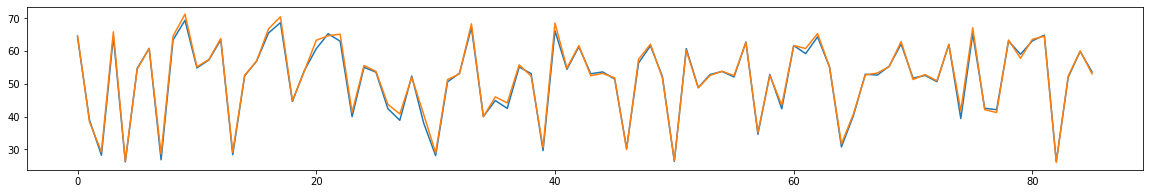

The r2 score of this prediction is :  0.9930332753077123
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 9s 250ms/step - loss: 0.1996 - mae: 0.3788
Epoch 2/10
11/11 [==============================] - 2s 192ms/step - loss: 0.0497 - mae: 0.1868
Epoch 3/10
11/11 [==============================] - 2s 185ms/step - loss: 0.0422 - mae: 0.1703
Epoch 4/10
11/11 [==============================] - 2s 180ms/step - loss: 0.0412 - mae: 0.1723
Epoch 5/10
11/11 [==============================] - 2s 181ms/step - loss: 0.0370 - mae: 0.1630
Epoch 6/10
11/11 [==============================] - 2s 182ms/step - loss: 0.0323 - mae: 0.1511
Epoch 7/10
11/11 [==============================] - 2s 180ms/step - loss: 0.0209 - mae: 0.1201
Epoch 8/10
11/11 [==============================] - 2s 179ms/step - loss: 0.0162 - mae: 0.1027
Epoch 9/10
11/11 [==============================] - 2s 169ms/step - loss: 0.0084 - mae: 0.0700
Epoch 10/10
11/11 [

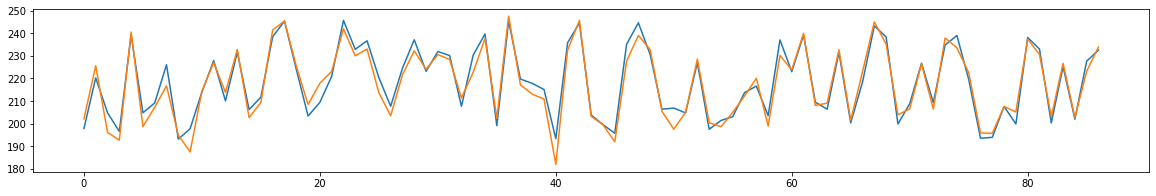

The r2 score of this prediction is :  0.9342423153611706
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 8s 252ms/step - loss: 0.1937 - mae: 0.3589
Epoch 2/10
11/11 [==============================] - 3s 248ms/step - loss: 0.0987 - mae: 0.2805
Epoch 3/10
11/11 [==============================] - 3s 250ms/step - loss: 0.1022 - mae: 0.2844
Epoch 4/10
11/11 [==============================] - 3s 247ms/step - loss: 0.0938 - mae: 0.2727
Epoch 5/10
11/11 [==============================] - 3s 249ms/step - loss: 0.0874 - mae: 0.2643
Epoch 6/10
11/11 [==============================] - 3s 247ms/step - loss: 0.0675 - mae: 0.2247
Epoch 7/10
11/11 [==============================] - 3s 245ms/step - loss: 0.0416 - mae: 0.1628
Epoch 8/10
11/11 [==============================] - 3s 286ms/step - loss: 0.0342 - mae: 0.1510
Epoch 9/10
11/11 [==============================] - 3s 249ms/step - loss: 0.0190 - mae: 0.1085
Epoch 10/10
11/11 [

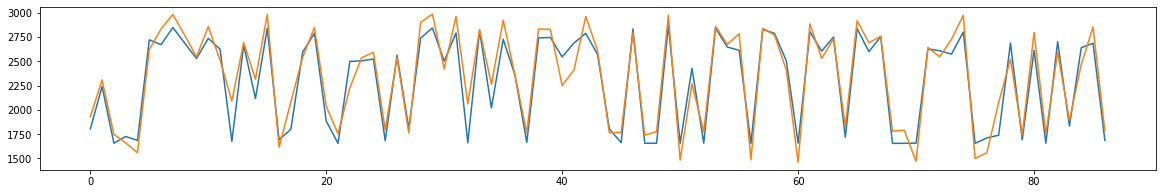

The r2 score of this prediction is :  0.9106727629292112
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 6s 145ms/step - loss: 0.1567 - mae: 0.3311
Epoch 2/10
11/11 [==============================] - 2s 148ms/step - loss: 0.0408 - mae: 0.1569
Epoch 3/10
11/11 [==============================] - 2s 155ms/step - loss: 0.0325 - mae: 0.1537
Epoch 4/10
11/11 [==============================] - 2s 152ms/step - loss: 0.0260 - mae: 0.1332
Epoch 5/10
11/11 [==============================] - 2s 150ms/step - loss: 0.0154 - mae: 0.1022
Epoch 6/10
11/11 [==============================] - 2s 151ms/step - loss: 0.0067 - mae: 0.0655
Epoch 7/10
11/11 [==============================] - 2s 150ms/step - loss: 0.0056 - mae: 0.0573
Epoch 8/10
11/11 [==============================] - 2s 149ms/step - loss: 0.0048 - mae: 0.0545
Epoch 9/10
11/11 [==============================] - 2s 150ms/step - loss: 0.0034 - mae: 0.0468
Epoch 10/10
11/11 [

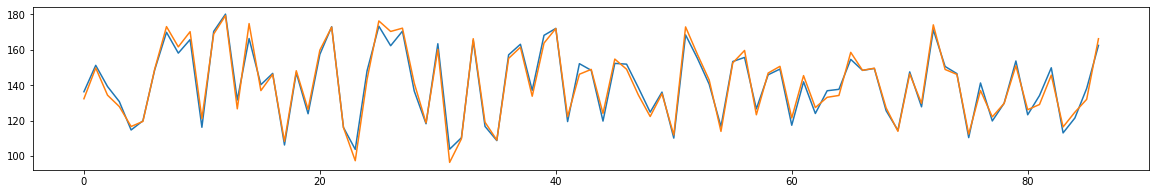

The r2 score of this prediction is :  0.9737632967195538
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 5s 7ms/step - loss: 0.2801 - mae: 0.4873
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.2421 - mae: 0.4473
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.1960 - mae: 0.3950
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.1334 - mae: 0.3171
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0557 - mae: 0.1906
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0338 - mae: 0.1456
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0267 - mae: 0.1296
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0254 - mae: 0.1260
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0228 - mae: 0.1186
Epoch 10/10
11/11 [==================

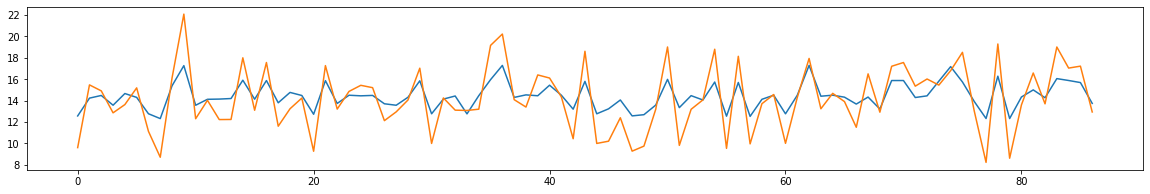

The r2 score of this prediction is :  0.5812669096969877
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 7s 119ms/step - loss: 0.1595 - mae: 0.3323
Epoch 2/10
11/11 [==============================] - 2s 146ms/step - loss: 0.0298 - mae: 0.1540
Epoch 3/10
11/11 [==============================] - 1s 133ms/step - loss: 0.0186 - mae: 0.1083
Epoch 4/10
11/11 [==============================] - 1s 117ms/step - loss: 0.0071 - mae: 0.0658
Epoch 5/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0029 - mae: 0.0454
Epoch 6/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0014 - mae: 0.0284
Epoch 7/10
11/11 [==============================] - 1s 113ms/step - loss: 0.0014 - mae: 0.0285
Epoch 8/10
11/11 [==============================] - 1s 112ms/step - loss: 0.0015 - mae: 0.0300
Epoch 9/10
11/11 [==============================] - 1s 106ms/step - loss: 0.0011 - mae: 0.0244
Epoch 10/10
11/11 [

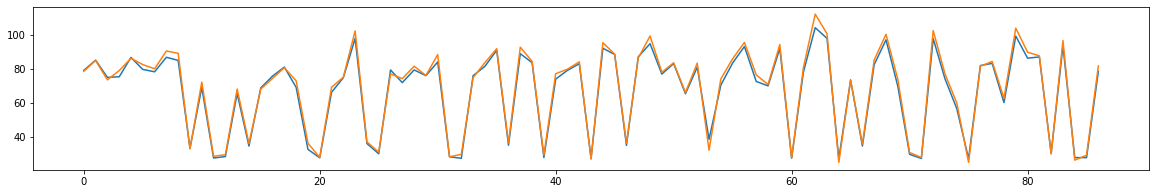

The r2 score of this prediction is :  0.9895078587031789


<Figure size 1440x216 with 0 Axes>

In [10]:
for i in ['OKE','ITW','GOOG','AAPL','SPRO', 'CHGG']:
    # Creates the training and testing sets from the dataframe 
    X, y = process_data(i)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    sc = MinMaxScaler()

    X_train = sc.fit_transform(X_train)

    X_test = sc.transform(X_test)

    weight, X_train_refit = perform_lasso(X_train, X_test)
    feature_names = X.columns

    weight_thresh = 0.1
    importance_dict = bar_importance(weight, X_train_refit, feature_names, weight_thresh)

    #Keeping the columns that are most contributing from all the feature values

    X = X.loc[:,list(importance_dict.keys())]

    create_model(X, y)